In [1]:
import numpy as np
from tqdm import tqdm
from scipy.special import erf
from matplotlib import colormaps
import matplotlib.pyplot as plt
from models import *
rng = np.random.default_rng()

## Model Training

In [2]:
N_Aiv = 300
conn_prob = 1

In [3]:
peak_rate, kernel_width = 150, 10

In [4]:
T_rend = 100 # Each rendition
N_rend = 20 # Number of renditions
T = N_rend * T_rend # Total

In [5]:
# Syllables and time stamps
syl = rng.normal(0, 1, size=(1, N_Aiv))
# ( 1, Number of renditions )
burst_ts = np.array([[T_rend * (j + 1/2) for j in range(N_rend)]])
save_W_ts = (burst_ts[0] + T_rend / 2 - 1).astype(int) # [0] to squeeze

In [6]:
_ = rng.standard_normal((1, N_rend)) # Little fluctuation
rH = generate_HVC(T, burst_ts, peak_rate+_*0.1, kernel_width+_*0.01)

In [7]:
aud = np.tile(syl, (T, 1))

In [8]:
rmax, s, th = 100, 1, 4
phi = lambda x: rmax/2 * (1 + erf((x - th) / (np.sqrt(2) * s)))

In [9]:
def bilin_hebb(W, aiv, hvc, lr, w0_mean, tau_w):
    # lr < 0, anti-Hebbian
    for i, h in enumerate(hvc):
        dW = lr * aiv * h - (W[:,i] - w0_mean) / tau_w
        W[:,i] = np.clip(W[:,i] + dW, a_min=0, a_max=None)

In [10]:
w0_mean, w0_std = 1, 0.1
JEE, JEI, JIE, JII = np.zeros(4)
tau_Aiv, tau_I, dt = 20, 10, 1

net = Aiv(N_Aiv, 1, conn_prob, w0_mean, w0_std, phi, tau_Aiv,
          tau_I, JEE, JEI, JIE, JII)

Aiv0, I0, ext_I = phi(rng.normal(0, 1, size=N_Aiv)), 1, 0

_ = net.sim(Aiv0, I0, rH, aud, save_W_ts, T, dt, 0.1, ext_I, bilin_hebb,
            lr=-5e-7, w0_mean=w0_mean, tau_w=5e7)
rA, rI, Ws, mean_HVC_input = _

Not a recurrent model and rI will not be calculated.


[Text(0.5, 0, 'Time (a.u.)'), Text(0, 0.5, 'mean input\nfrom HVC')]

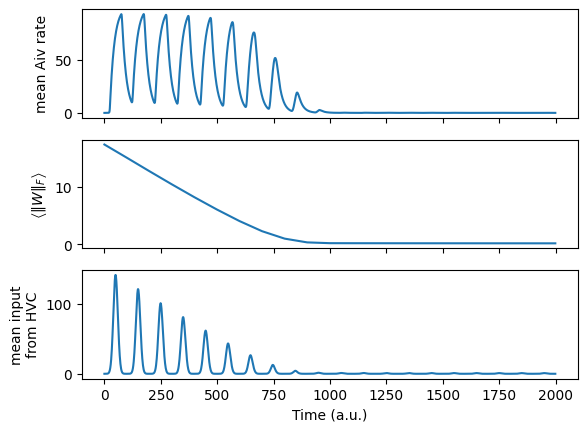

In [11]:
W_norms = np.array([np.linalg.norm(_, ord='fro') for _ in Ws]) # Frobenius norm
fig, ax = plt.subplots(3, sharex='all')
ax[0].plot(rA.mean(axis=1))
ax[1].plot(np.hstack([[0], save_W_ts]), W_norms)
ax[2].plot(mean_HVC_input)
ax[0].set(ylabel='mean Aiv rate')
ax[1].set(ylabel=r'$\left\langle \| W \|_F \right\rangle$')
ax[2].set(xlabel='Time (a.u.)', ylabel='mean input\nfrom HVC')

In [12]:
W_syl_corrs = [correlation(_.T, syl, lambda x: x) for _ in Ws]

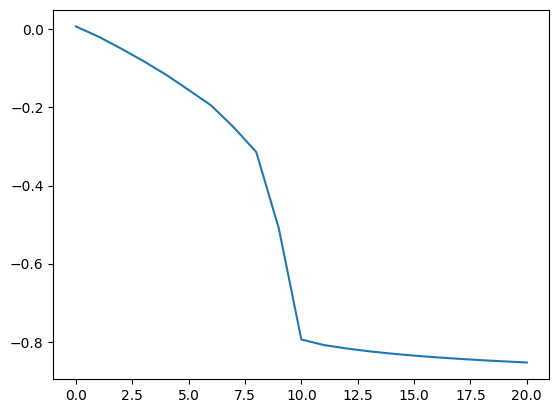

In [13]:
plt.plot(list(map(lambda x: x.flatten(), W_syl_corrs)))

0.9704425373955519

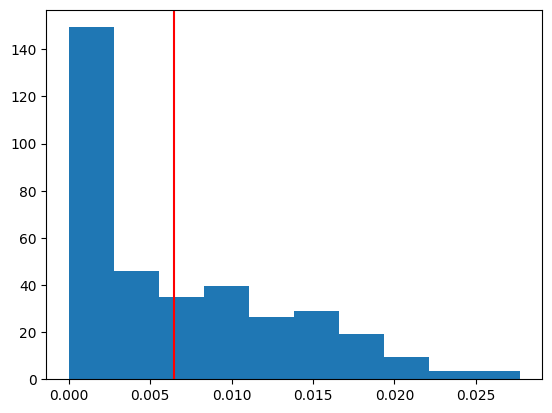

In [14]:
plt.hist(Ws[-1].flatten(), density=True, bins=10)
plt.axvline(Ws[-1].mean(), color='r')
# plt.axvline(w0_mean, color='k')
Ws[-1].mean() * peak_rate

## Error Code for Deterministic Perturbation

In [15]:
# Not used unless introduce multidimensional noise
eigvecs = np.linalg.qr(rng.random(size=(N_Aiv, N_Aiv)))[0]
eigvals = np.sort(rng.random(size=N_Aiv))[::-1]

In [16]:
def plot_drA_deps_over_time(drA_deps, eps0s, idx=None):
    fig, ax = plt.subplots(2, len(eps0s), sharex='all', sharey='row', figsize=(len(eps0s)*2, 4))
    if len(eps0s) == 1:
        ax = ax[:,None]
    if idx is None:
        idx = rng.integers(0, N_Aiv)
    ts = np.arange(0, drA_deps.shape[1] * 0.1, step=0.1)
    for i in range(len(eps0s)):
        ax[0,i].plot(ts, drA_deps[i,:,idx,:], color='b', alpha=0.3, lw=1)
        ax[0,i].plot(ts, drA_deps[i,:,idx,idx], color='r')
        ax[0,i].axhline(0, color='k', ls=':')
        ax[0,i].set(title=r'$\bar\boldsymbol{\epsilon}$' + ' = %.2f' % eps0s[i])
        ax[1,i].plot(ts, drA_deps[i,:,:,:].mean(axis=1), color='grey', alpha=0.3, lw=1)
        ax[1,i].axhline(0, color='k', ls=':')
        ax[1,i].set(xlabel='Time')
    ax[0,0].set_ylabel(r'$\partial r^A_i / \partial \bar \epsilon_j$', fontsize=12)
    ax[1,0].set_ylabel(r'$\partial \bar r^A / \partial \bar \epsilon_j$', fontsize=12)
    fig.tight_layout()
    return fig, ax

In [17]:
def plot_sparse(ax, mat, th=0.1, clip_max=None):
    a_mat = np.abs(mat)
    rows, cols = np.where(a_mat > th)
    if len(rows) > 5000:
        idx = rng.choice(np.arange(0, len(rows)), size=2000, replace=False)
        rows, cols = rows[idx], cols[idx]
    if clip_max is None:
        clip_max = a_mat[rows, cols].mean()
    colors = np.clip(a_mat[rows, cols], a_min=th, a_max=clip_max)
    ax.scatter(cols, rows, c=colors, s=1, cmap='binary')
    
def plot_sparse_multi(drA_deps, eps0s, th=0.1, clip_max=None):
    fig, ax = plt.subplots(1, len(eps0s), sharex='all', sharey='all', figsize=(len(eps0s)*2, 2.5))
    if len(eps0s) == 1:
        ax = [ax]
    for i in range(len(eps0s)):
        plot_sparse(ax[i], drA_deps[i, -1], th, clip_max)
        ax[i].set(title=r'$\bar \epsilon$' + '= %.2f' % eps0s[i], xticks=[], yticks=[], 
                  ylabel='Aiv index', xlabel=r'$\bar \epsilon$ index')
    fig.suptitle(r'$\partial r^A_i / \partial \bar \epsilon_j$')
    fig.tight_layout()
    return fig, ax

In [18]:
def plot_dist(drA_d_, var_name, cond, cond_name, func, ts, dt, range_, bins=20):
    '''
    drA_d_: (Number of conditions, Time, Number of Aiv, ...)
    cond: conditions or conditional vars
    func: applied to the rest of the dimension(s) of drA_d_[i,t,:,...]
    ts: time steps to plot
    '''
    fig, ax = plt.subplots(1, len(cond), sharex='all', sharey='all', 
                           figsize=(len(cond)*2, 2.5))
    ts = sorted(ts) # ascending order
    if len(cond) == 1:
        ax = [ax]
    cmap = colormaps.get_cmap('plasma')
    for i in range(len(cond)):
        for j, t in enumerate(ts):
            c = cmap(j/len(ts))
            ax[i].hist(func(drA_d_[i, t]), bins=bins, range=range_, density=True,
                       histtype='stepfilled', fc=[*c[:-1], 0.3], ec=c, 
                       label='%d' % np.round(t * dt), zorder=1-j/len(ts))
        ax[i].set(title=cond_name + '= %.2f' % cond[i])
        ax[i].set_xlabel(var_name, fontsize=12)
    ax[0].set(ylabel='Density')
    ax[0].legend()
    fig.tight_layout()
    return fig, ax

In [19]:
def plot_joint_dist(syl, drA_d_, var_name, cond, cond_name, func, ts, dt):
    '''
    drA_d_: (Number of conditions, Time, Number of Aiv, ...)
    cond: conditions or conditional vars
    func: applied to the rest of the dimension(s) of drA_d_[i,t,:,...]
    ts: time steps to plot
    '''
    fig, ax = plt.subplots(1, len(cond), sharex='all', sharey='row', 
                           figsize=(len(cond)*2, 2.5))
    if len(cond) == 1:
        ax = [ax]
    cmap = colormaps.get_cmap('viridis')
    for i in range(len(cond)):
        for t in ts:
            ax[i].scatter(syl, func(drA_d_[i, t]), label='%d' % np.round(t * dt), 
                          color=cmap(t/drA_d_.shape[1]), s=3)
        ax[i].set(title=cond_name + '= %.2f' % cond[i], xlabel=r'$\xi_i$')
    ax[0].set_ylabel(var_name, fontsize=12)
    ax[0].legend()
    fig.tight_layout()
    return fig, ax

In [20]:
def deterministic_perturb(eps0s, eps_unperturbed=None, deps=0.05, rH=peak_rate):
    Aiv0, I0 = np.ones(N_Aiv), 1
    _T_rend, dt = 2000, 0.1
    
    rH_ = np.zeros((_T_rend, 1)) + rH

    drA_deps = np.zeros((len(eps0s), _T_rend, N_Aiv, N_Aiv)) # rA dim first, then perturb dim
    rA_mean = np.zeros((len(eps0s), _T_rend))
    
    perturb = np.zeros(N_Aiv)
    if eps_unperturbed is not None:
        perturb += eps_unperturbed
    
    aud_ = np.tile(syl, (_T_rend, 1))
    for i in range(len(eps0s)):
        for j in tqdm(range(N_Aiv)):
            # noise = rng.standard_normal(size=(_T_rend, N_Aiv)) * 0
    
            if eps_unperturbed is None:
                perturb[:] = eps0s[i]
                perturb[j] = eps0s[i] - deps
            else:
                perturb[[j-1,j]] = [eps_unperturbed, eps0s[i]-deps]
            _ = aud_ + perturb[None,:] #+ noise @ (eigvecs * np.sqrt(eigvals[:,None])).T
            res_l = net.sim(Aiv0, I0, rH_, _, [], _T_rend, dt, 0, ext_I)[0]
            
            if eps_unperturbed is None:
                perturb[:] = eps0s[i]
                perturb[j] = eps0s[i] + deps
            else:
                perturb[[j-1,j]] = [eps_unperturbed, eps0s[i]+deps]
            _ = aud_ + perturb[None,:] #+ noise @ (eigvecs * np.sqrt(eigvals[:,None])).T
            res_r = net.sim(Aiv0, I0, rH_, _, [], _T_rend, dt, 0, ext_I)[0]
            
            drA_deps[i, :, :, j] = res_r - res_l
            rA_mean[i] = res_r.mean(axis=1)
    
    if deps != 0:
        drA_deps /= deps * 2
    return drA_deps, rA_mean

In [21]:
eps0s = (0.2, 0.8, 1.4)
drA_deps, rA_mean_eps = deterministic_perturb(eps0s, deps=0.05)

100%|█████████████████████████████████████████| 300/300 [00:38<00:00,  7.80it/s]


[Text(0, 0.5, '$\\bar r^A$'), Text(0.5, 0, 'Time')]

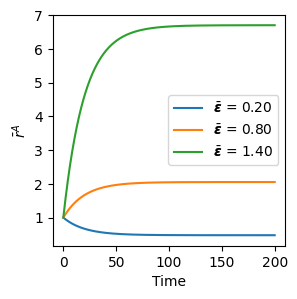

In [22]:
fig, ax = plt.subplots(1, figsize=(3,3))
_ = np.arange(0, rA_mean_eps.shape[1] * 0.1, 0.1)
for i, eps0 in enumerate(eps0s):
    ax.plot(_, rA_mean_eps[i], label=r'$\bar\boldsymbol{\epsilon}$' + ' = %.2f' % eps0)
ax.legend()
ax.set(ylabel=r'$\bar r^A$', xlabel='Time')

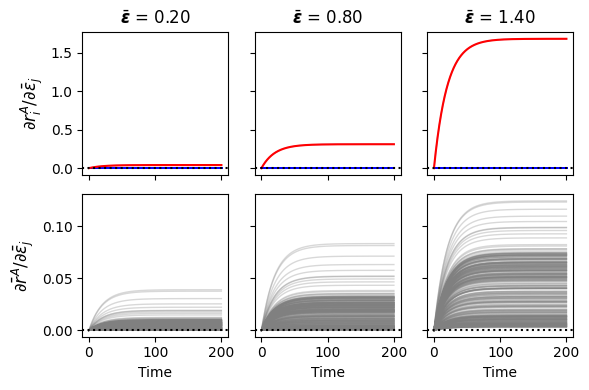

In [23]:
plot_drA_deps_over_time(drA_deps, eps0s);

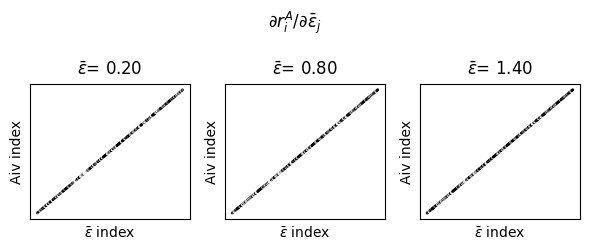

In [24]:
plot_sparse_multi(drA_deps, eps0s, 0.1);

In [25]:
# fig, ax = plot_diag_dist(drA_deps, eps0s, ts=[99, 499, 1999], dt=0.1, range_=(0, 50))

[None]

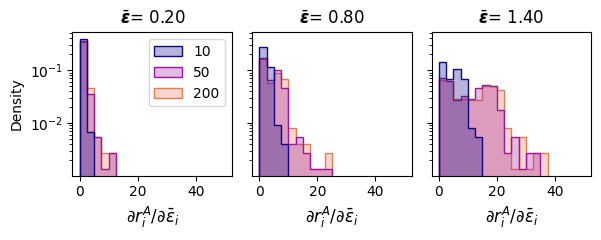

In [26]:
fig, ax = plot_dist(drA_deps, r'$\partial r^A_i/\partial \bar\epsilon_i$', eps0s, 
                    r'$\bar\boldsymbol{\epsilon}$', lambda x: np.diag(x), 
                    ts=[99, 499, 1999], dt=0.1, range_=(0, 50))
ax[0].set(yscale='log')

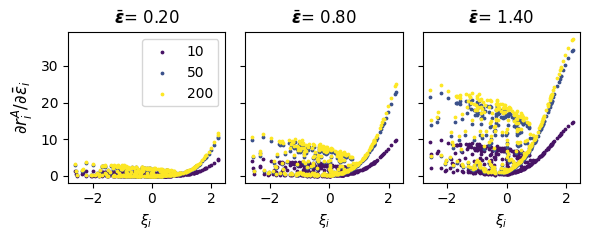

In [27]:
plot_joint_dist(syl[0], drA_deps, r'$\partial r^A_i / \partial \bar\epsilon_i$', 
                eps0s, r'$\bar\boldsymbol{\epsilon}$', lambda x: np.diag(x), 
                ts=[99, 499, 1999], dt=0.1);

## Error Code for the Eigenvalue of Perturbation Noise

In [28]:
def noise_perturb(lams, eps0, sparsity, dlam=0.05, rH=peak_rate):
    Aiv0, I0 = np.ones(N_Aiv), 1
    rep = 50 # repeat x times
    _T_rend, dt = 2000, 0.1
    
    rH_ = np.zeros((_T_rend, 1)) + rH
    
    drA_dlam = np.zeros((len(lams), _T_rend, N_Aiv, rep)) 
    rA_mean = np.zeros((len(lams), _T_rend, rep))

    if sparsity > 0:
        idx = rng.choice(np.arange(N_Aiv), size=int(N_Aiv*sparsity), replace=False)
    aud_ = np.tile(syl, (_T_rend, 1))
    for i in tqdm(range(len(lams))):
        for j in range(rep):
            vec = np.ones(N_Aiv)
            if sparsity > 0:
                vec[idx] = 0 # Sparse eigenvec
            vec /= np.linalg.norm(vec)
            noise = rng.standard_normal(size=(_T_rend, N_Aiv)) * vec
    
            _ = aud_ + eps0 + noise * np.sqrt(lams[i] - dlam)
            res_l = net.sim(Aiv0, I0, rH_, _, [], _T_rend, dt, 0, ext_I)[0]
            
            _ = aud_ + eps0 + noise * np.sqrt(lams[i] + dlam)
            res_r = net.sim(Aiv0, I0, rH_, _, [], _T_rend, dt, 0, ext_I)[0]
            
            drA_dlam[i, :, :, j] = res_r - res_l
            rA_mean[i, :, j] = res_r.mean(axis=1)
            
    if dlam != 0:
        drA_dlam /= dlam * 2
    return drA_dlam, rA_mean

In [29]:
lams = np.linspace(0.1, 1.6, num=4)
lams

array([0.1, 0.6, 1.1, 1.6])

### Eigenvector has few zero elements

#### Small Deterministic Perturbation

In [30]:
drA_dlam, rA_mean_lam = noise_perturb(lams, eps0=0.2, sparsity=0)

100%|█████████████████████████████████████████████| 4/4 [00:29<00:00,  7.41s/it]


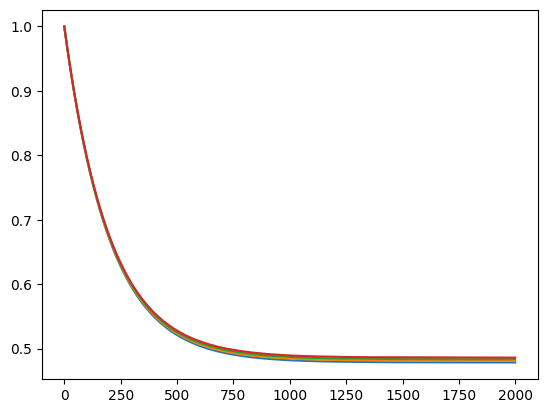

In [31]:
plt.plot(rA_mean_lam.mean(axis=-1).T);

[None]

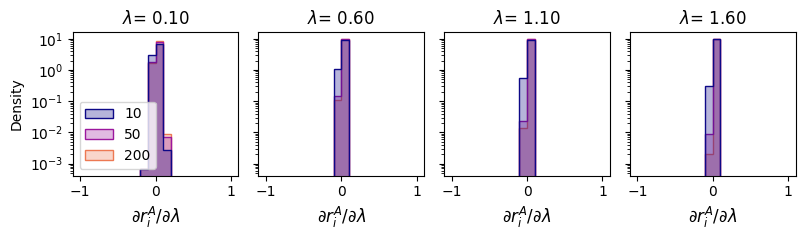

In [32]:
fig, ax = plot_dist(drA_dlam, r'$\partial r^A_i/\partial \lambda$', lams, 
                    r'$\lambda$', lambda x: x.flatten(), ts=[99, 499, 1999], 
                    dt=0.1, range_=(-1, 1))
ax[0].set(yscale='log')

[None]

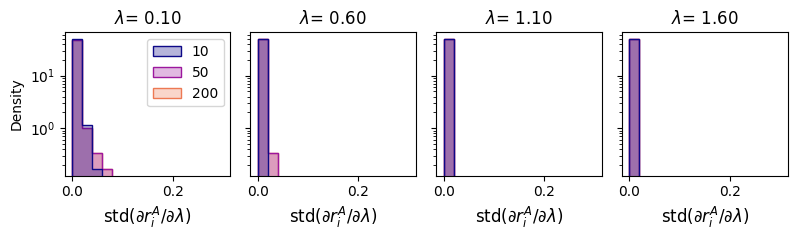

In [33]:
fig, ax = plot_dist(drA_dlam, r'std($\partial r^A_i/\partial \lambda$)', lams, 
                    r'$\lambda$', lambda x: x.std(axis=-1), ts=[99, 499, 1999], 
                    dt=0.1, range_=(0, 0.3), bins=15)
ax[0].set(yscale='log')

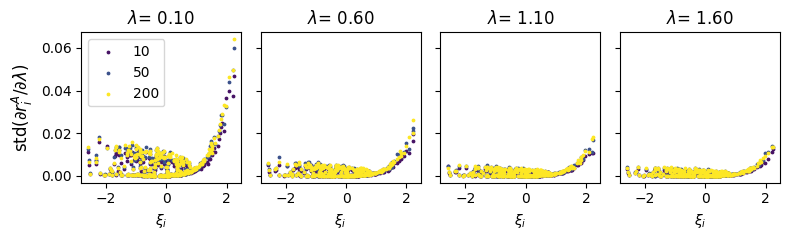

In [34]:
plot_joint_dist(syl[0], drA_dlam, r'std($\partial r^A_i / \partial \lambda$)', 
                lams, r'$\lambda$', lambda x: x.std(axis=-1), ts=[99, 499, 1999], dt=0.1);

#### Large Deterministic Perturbation

In [35]:
drA_dlam, rA_mean_lam = noise_perturb(lams, eps0=0.8, sparsity=0)

100%|█████████████████████████████████████████████| 4/4 [00:28<00:00,  7.19s/it]


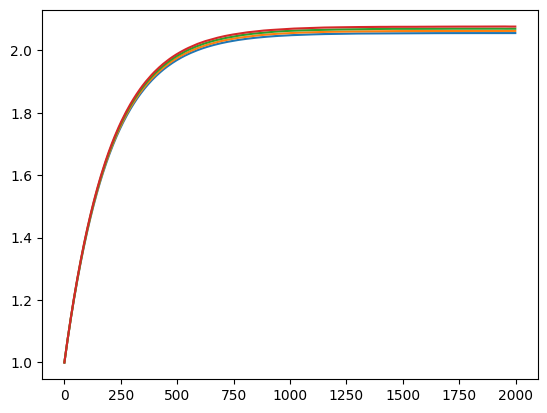

In [36]:
plt.plot(rA_mean_lam.mean(axis=-1).T);

[None]

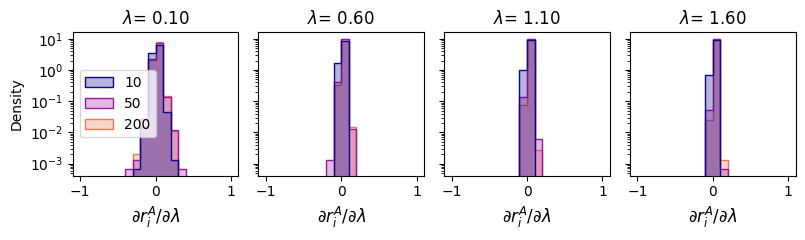

In [37]:
fig, ax = plot_dist(drA_dlam, r'$\partial r^A_i/\partial \lambda$', lams, 
                    r'$\lambda$', lambda x: x.flatten(), ts=[99, 499, 1999], 
                    dt=0.1, range_=(-1, 1))
ax[0].set(yscale='log')

[None]

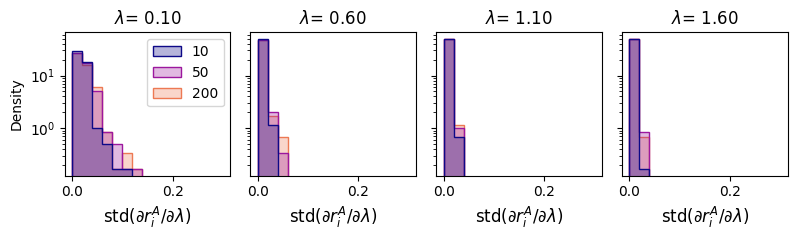

In [38]:
fig, ax = plot_dist(drA_dlam, r'std($\partial r^A_i/\partial \lambda$)', lams, 
                    r'$\lambda$', lambda x: x.std(axis=-1), ts=[99, 499, 1999], 
                    dt=0.1, range_=(0, 0.3), bins=15)
ax[0].set(yscale='log')

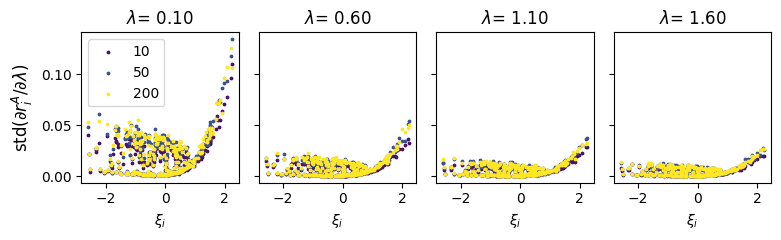

In [39]:
plot_joint_dist(syl[0], drA_dlam, r'std($\partial r^A_i / \partial \lambda$)', 
                lams, r'$\lambda$', lambda x: x.std(axis=-1), ts=[99, 499, 1999], dt=0.1);

### Eigenvector has many zero elements (degenerate noise)

In [40]:
drA_dlam, rA_mean_lam = noise_perturb(lams, eps0=0.8, sparsity=0.4)

100%|█████████████████████████████████████████████| 4/4 [00:28<00:00,  7.07s/it]


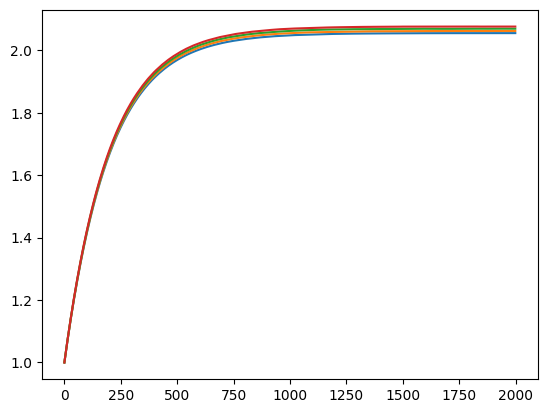

In [41]:
plt.plot(rA_mean_lam.mean(axis=-1).T);

[None]

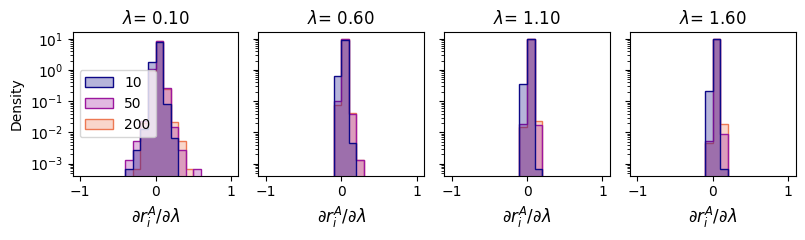

In [42]:
fig, ax = plot_dist(drA_dlam, r'$\partial r^A_i/\partial \lambda$', lams, 
                    r'$\lambda$', lambda x: x.flatten(), ts=[99, 499, 1999], 
                    dt=0.1, range_=(-1, 1))
ax[0].set(yscale='log')

[None]

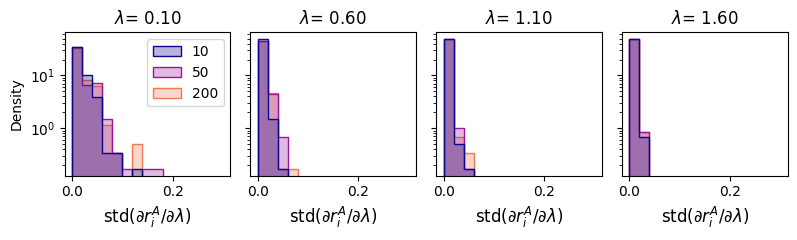

In [43]:
fig, ax = plot_dist(drA_dlam, r'std($\partial r^A_i/\partial \lambda$)', lams, 
                    r'$\lambda$', lambda x: x.std(axis=-1), ts=[99, 499, 1999], 
                    dt=0.1, range_=(0, 0.3), bins=15)
ax[0].set(yscale='log')

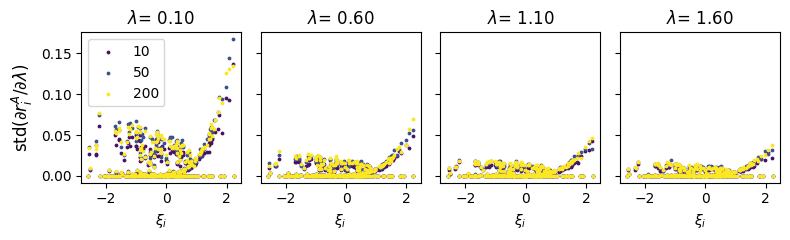

In [44]:
plot_joint_dist(syl[0], drA_dlam, r'std($\partial r^A_i / \partial \lambda$)', 
                lams, r'$\lambda$', lambda x: x.std(axis=-1), ts=[99, 499, 1999], dt=0.1);